# Content-based Image search engine using autoencoders

How to use convolutional autoencoders to create a Content-based Image Retrieval system.

Image search engines are similar to text search engines, only instead of presenting the search engine with a text query, you instead provide an image query — the image search engine then finds all visually similar/relevant images in its database and returns them to you (just as a text search engine would return links to articles, blog posts, etc.).


<img src="https://www.pyimagesearch.com/wp-content/uploads/2020/03/keras_autoencoder_steps.png" width="500">


Original source https://www.pyimagesearch.com/2020/03/30/autoencoders-for-content-based-image-retrieval-with-keras-and-tensorflow/

In [37]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
from pyimagesearch.imageutils import display
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2

## Implementing image indexer using the trained autoencoder

[INFO] loading autoencoder model...
[INFO] loading MNIST training split...
(60000, 28, 28, 1)


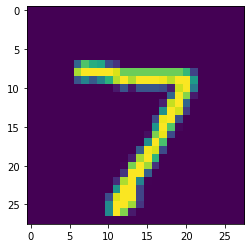

In [38]:
args = {}
args["model"] = "downloads/models-cia/imagesearch/autoencoder.h5"
args["index"] = "downloads/models-cia/imagesearch/features.pickle"
args["sample"] = 10

# load our autoencoder from disk
print("[INFO] loading autoencoder model...")
autoencoder = load_model(args["model"])

# load the MNIST dataset
print("[INFO] loading MNIST training split...")
((trainX, _), (testX, _)) = mnist.load_data()
plt.imshow(testX[0])

# add a channel dimension to every image in the training split
trainX = np.expand_dims(trainX, axis=-1)
print(trainX.shape)

In [39]:
# scale the pixel intensities to the range [0, 1]
trainX = trainX.astype("float32") / 255.0

# create the encoder model which consists of *just* the encoder portion of the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("encoded").output)

# quantify the contents of our input images using the encoder
print("[INFO] encoding images...")
features = encoder.predict(trainX)

# construct a dictionary that maps the index of the MNIST training
# image to its corresponding latent-space representation
indexes = list(range(0, trainX.shape[0]))
data = {"indexes": indexes, "features": features}

# write the data dictionary to disk
print("[INFO] saving index...")
f = open(args["index"], "wb")
f.write(pickle.dumps(data))
f.close()

[INFO] encoding images...
[INFO] saving index...


## Searching image

In [40]:
def euclidean(a, b):
	# compute and return the euclidean distance between two vectors
	return np.linalg.norm(a - b)

def perform_search(queryFeatures, index, maxResults=64):
	# initialize our list of results
	results = []

	# loop over our index
	for i in range(0, len(index["features"])):
		# compute the euclidean distance between our query features
		# and the features for the current image in our index, then
		# update our results list with a 2-tuple consisting of the
		# computed distance and the index of the image
		d = euclidean(queryFeatures, index["features"][i])
		results.append((d, i))

	# sort the results and grab the top ones
	results = sorted(results)[:maxResults]

	# return the list of results
	return results

[INFO] loading MNIST dataset...
[INFO] loading autoencoder and index...
[INFO] encoding testing images...


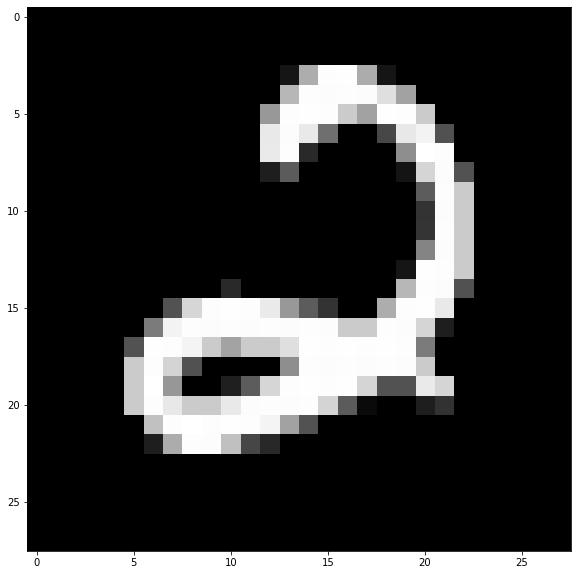

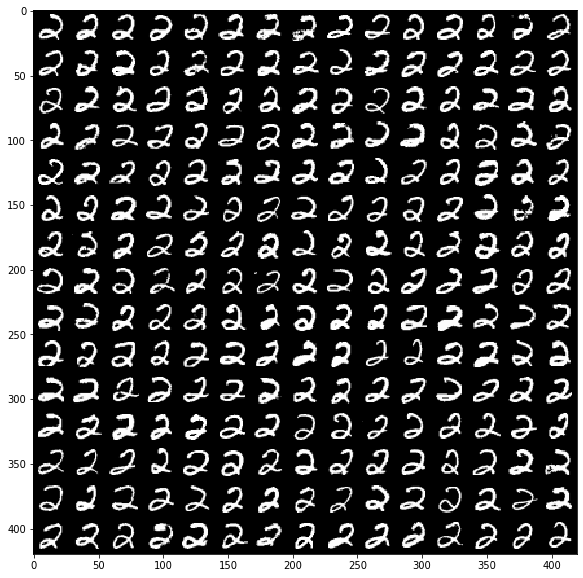

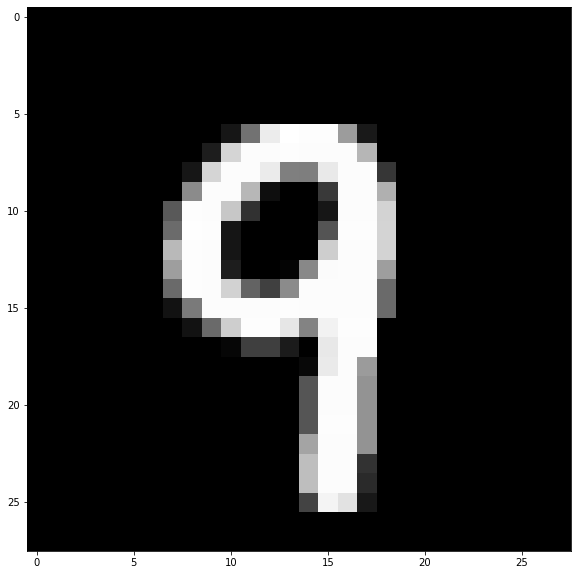

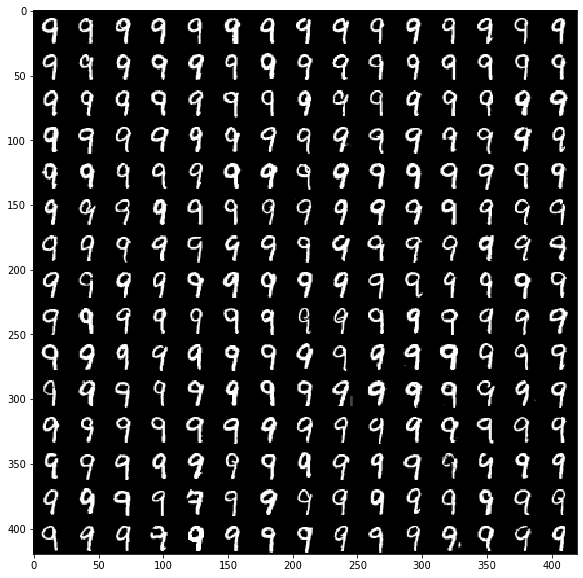

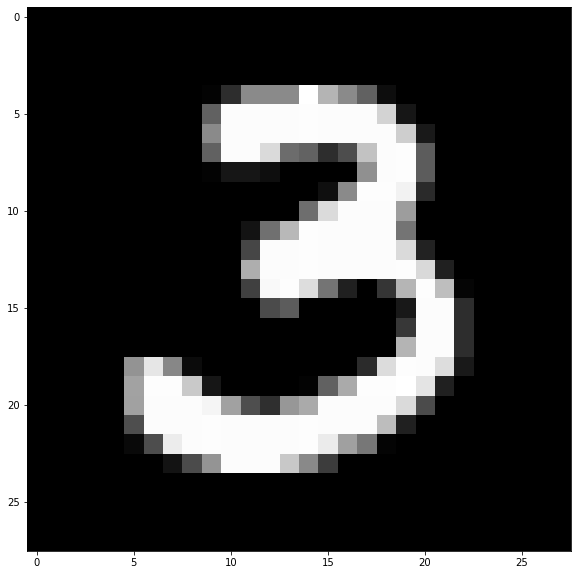

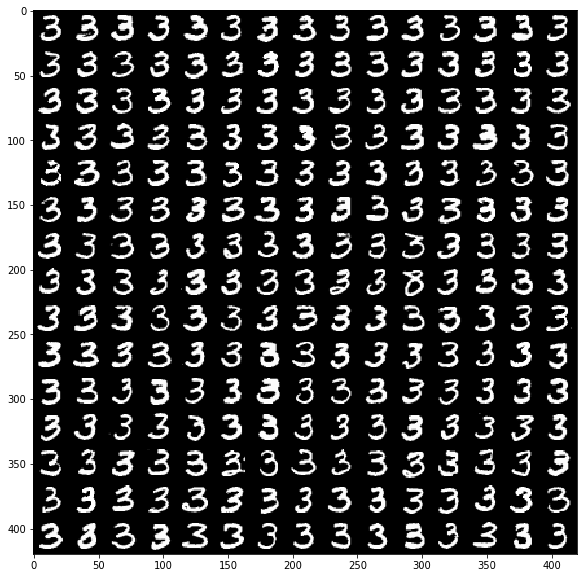

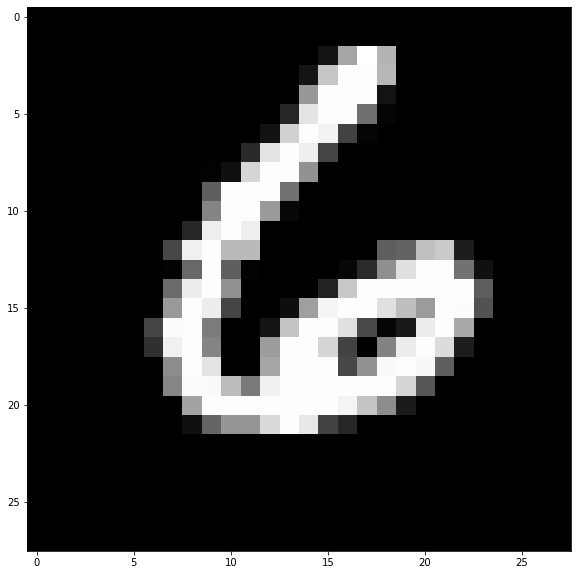

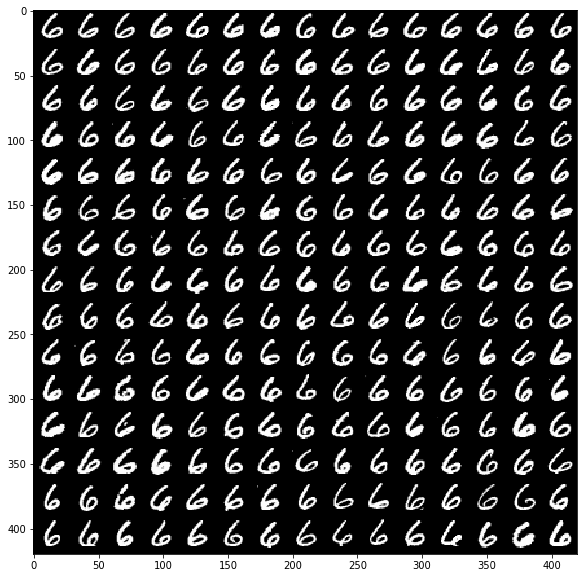

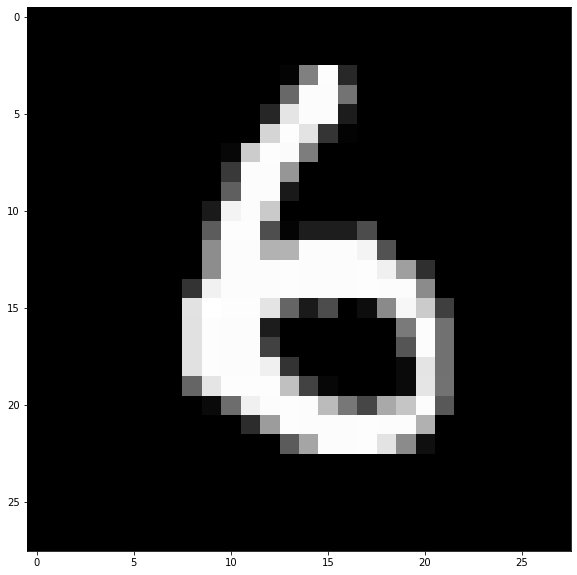

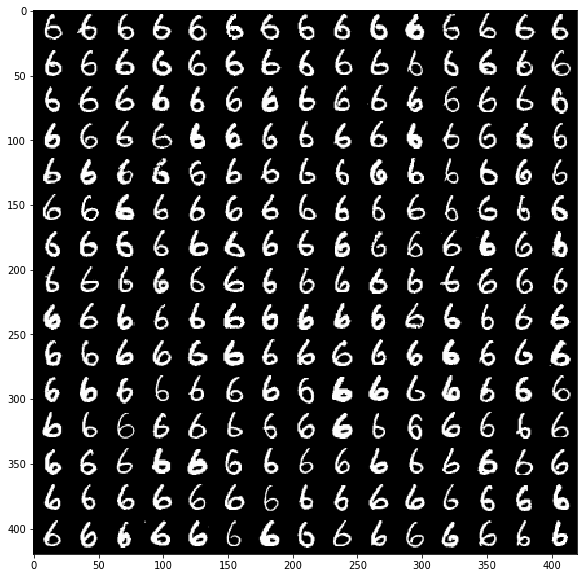

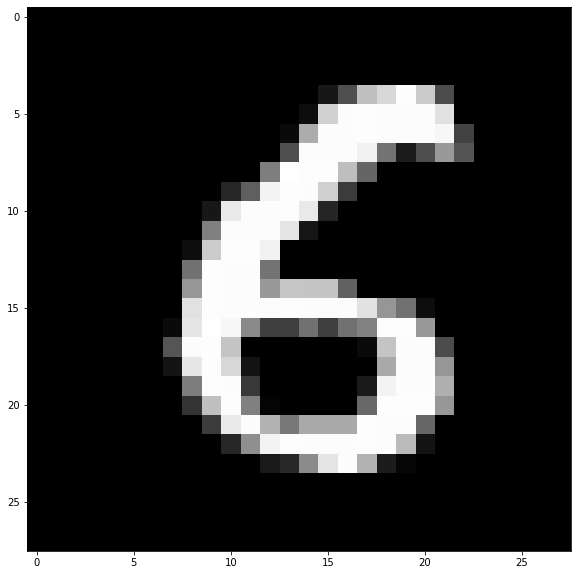

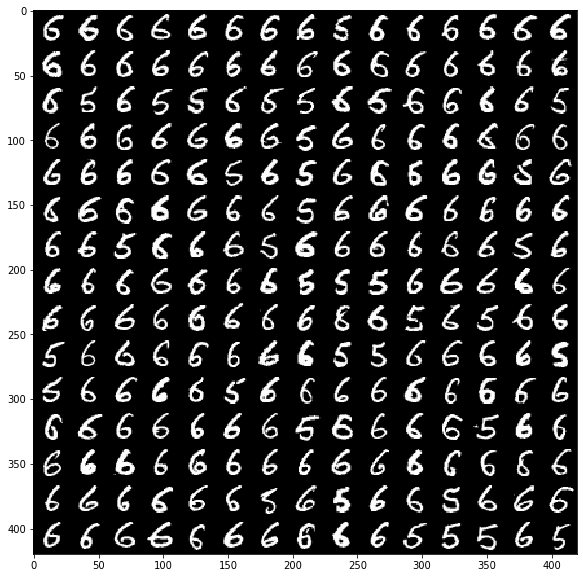

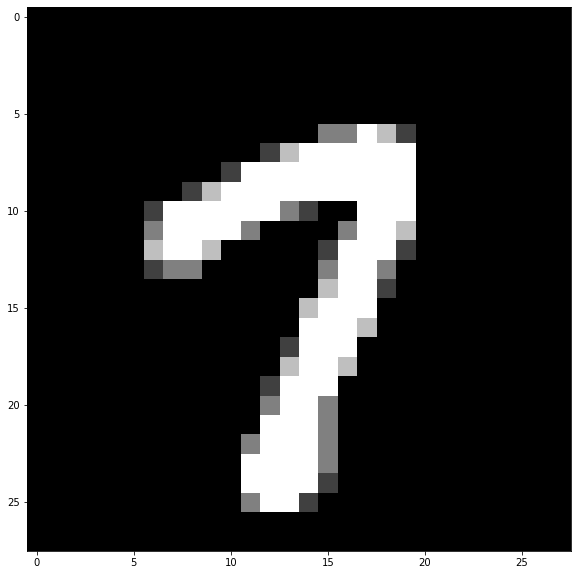

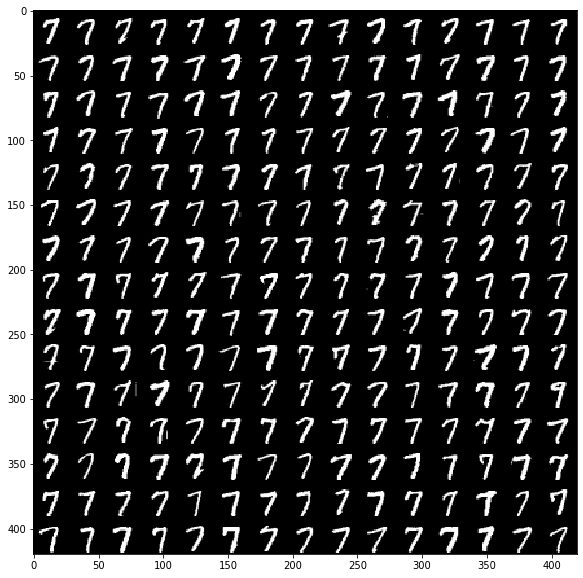

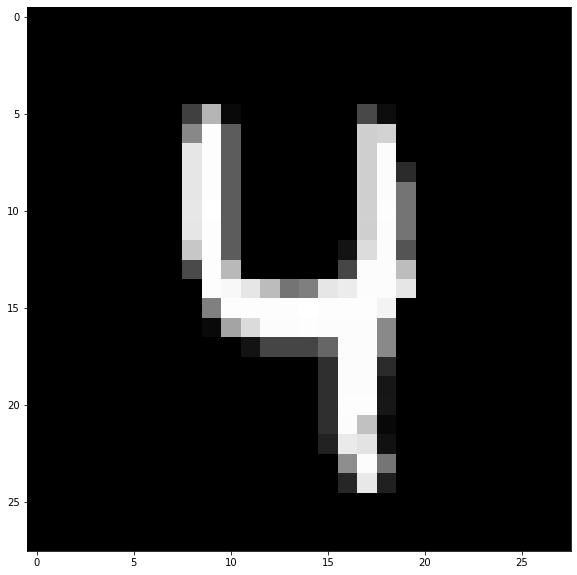

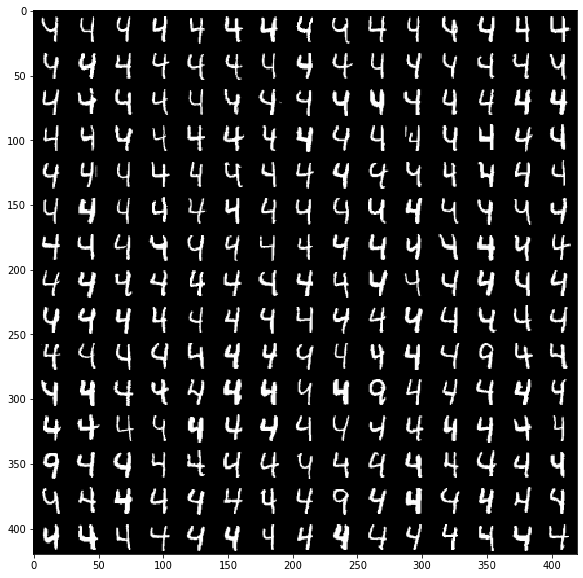

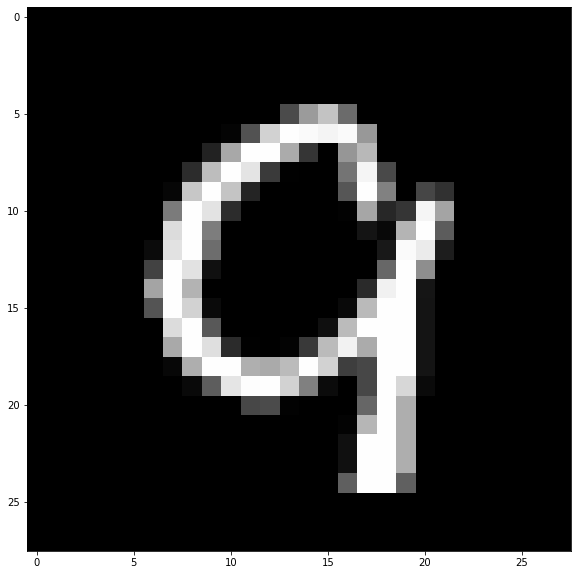

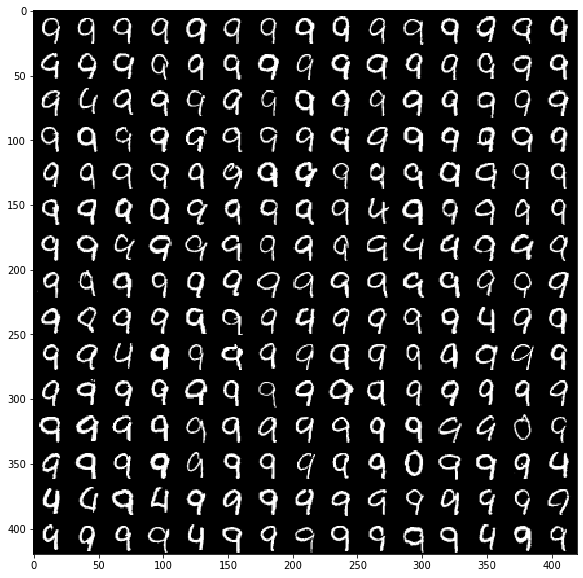

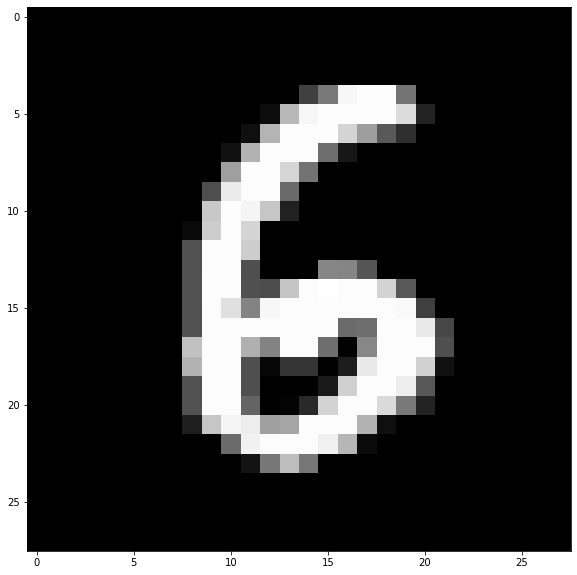

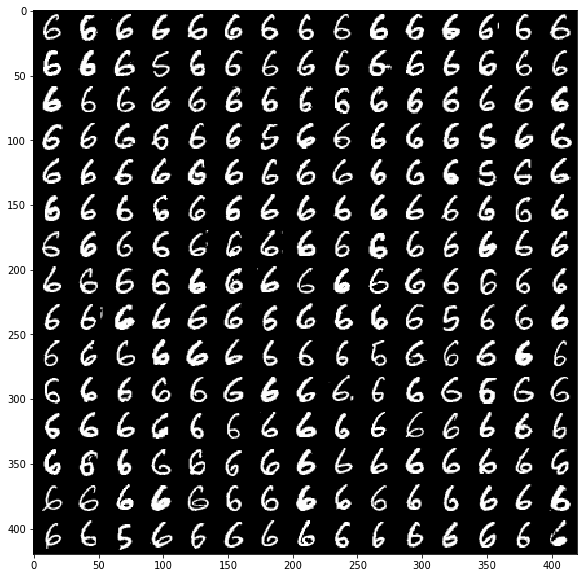

In [41]:
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# load the autoencoder model and index from disk
print("[INFO] loading autoencoder and index...")
autoencoder = load_model(args["model"])
index = pickle.loads(open(args["index"], "rb").read())

# create the encoder model which consists of *just* the encoder
# portion of the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("encoded").output)

# quantify the contents of our input testing images using the encoder
print("[INFO] encoding testing images...")
features = encoder.predict(testX)

# randomly sample a set of testing query image indexes
queryIdxs = list(range(0, testX.shape[0]))
queryIdxs = np.random.choice(queryIdxs, size=args["sample"], replace=False)

# loop over the testing indexes
for i in queryIdxs:
	# take the features for the current image, find all similar
	# images in our dataset, and then initialize our list of result images
	queryFeatures = features[i]
	results = perform_search(queryFeatures, index, maxResults=225)
	images = []

	# loop over the results
	for (d, j) in results:
		# grab the result image, convert it back to the range
		# [0, 255], and then update the images list
		image = (trainX[j] * 255).astype("uint8")
		image = np.dstack([image] * 3)
		images.append(image)

	# display the query image
	query = (testX[i] * 255).astype("uint8")
	display(query)

	# build a montage from the results and display it
	montage = build_montages(images, (28, 28), (15, 15))[0]
	display(montage)